In [1]:
import pickle

import numpy as np
import pymc3 as pm
import theano.tensor as tt
import pymbar

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from _BAR_estimator import get_values_from_trace
from _BAR_estimator import bayes_factor_smc
from _BAR_estimator import fit_normal_trace
from _BAR_estimator import draw_normal_samples
from _BAR_estimator import pot_ener_normal_aug
from _BAR_estimator import pot_ener
from _BAR_estimator import bootstrap_BAR
from _BAR_estimator import fit_uniform_trace
from _BAR_estimator import draw_uniform_samples
from _BAR_estimator import pot_ener_uniform_aug

In [2]:
SEED = 2039
SIZE = 50

SMC_STEPS = 10000
MET_STEPS = 100000

# Data Generation

In [3]:
def gaussian_mixture(mu1=0, sigma1=1, mu2=0, sigma2=1,
                     rho=0.5, size=100, random_state=None):
    rnd = np.random.RandomState(random_state)
    x = []
    for _ in range(size):
        if rnd.rand() < rho:
            x.append(rnd.normal(loc=mu1, scale=sigma1))
        else:
            x.append(rnd.normal(loc=mu2, scale=sigma2))
    return np.array(x)

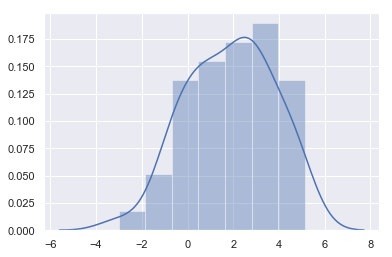

In [4]:
x = gaussian_mixture(mu1=0, sigma1=1, mu2=3, sigma2=1, rho=0.5, size=SIZE, random_state=SEED)
sns.distplot(x)

# Models

## Model 1

In [5]:
with pm.Model() as model_m1:
    mu = pm.Uniform("mu", lower=-10, upper=10)
    sigma = pm.Uniform("sigma", lower=0.1, upper=5)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=x)

print(model_m1.vars)

[mu_interval__, sigma_interval__]


## Model 2

In [6]:
with pm.Model() as model_m2:
    w = pm.floatX([.5, .5])
    sigmas = pm.floatX([1., 1])
    
    mu = pm.Uniform("mu", lower=-10, upper=10)
    dmu = pm.Uniform("dmu", lower=0, upper=10)
    means = tt.zeros([2])
    means = tt.set_subtensor(means[0], mu)
    means = tt.set_subtensor(means[1], mu + dmu)
    
    sigma1 = pm.Uniform("sigma1", lower=0.1, upper=5)
    sigma2 = pm.Uniform("sigma2", lower=0.1, upper=5)
    sigmas = tt.zeros([2])
    sigmas = tt.set_subtensor(sigmas[0], sigma1)
    sigmas = tt.set_subtensor(sigmas[1], sigma2)
    
    obs = pm.NormalMixture("obs", w=w, mu=means, sigma=sigmas, observed=x)

print(model_m2.vars)

[mu_interval__, dmu_interval__, sigma1_interval__, sigma2_interval__]


# Sequential Monte Carlo

Sample initial stage: ...
Stage: 0 Beta: 0.002 Steps: 25
Stage: 1 Beta: 0.019 Steps: 7
Stage: 2 Beta: 0.141 Steps: 3
Stage: 3 Beta: 1.000 Steps: 5


Log10 marginal likelihood: -59.81417


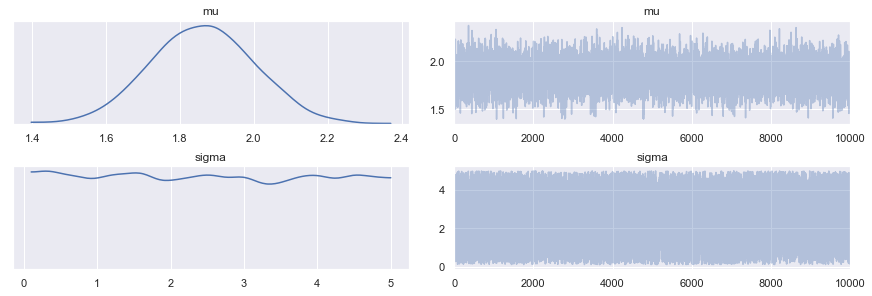

In [7]:
with model_m1:
    trace_m1 = pm.sample(SMC_STEPS, step=pm.SMC())
pm.traceplot(trace_m1[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_m1.marginal_likelihood)))

pickle.dump(model_m1, open("data/model_m1_smc.pickle", "wb"))

Sample initial stage: ...
Stage: 0 Beta: 0.026 Steps: 25
Stage: 1 Beta: 0.084 Steps: 13
Stage: 2 Beta: 0.189 Steps: 3
Stage: 3 Beta: 0.392 Steps: 11
Stage: 4 Beta: 0.822 Steps: 4
Stage: 5 Beta: 1.000 Steps: 10


Log10 marginal likelihood: -47.75617


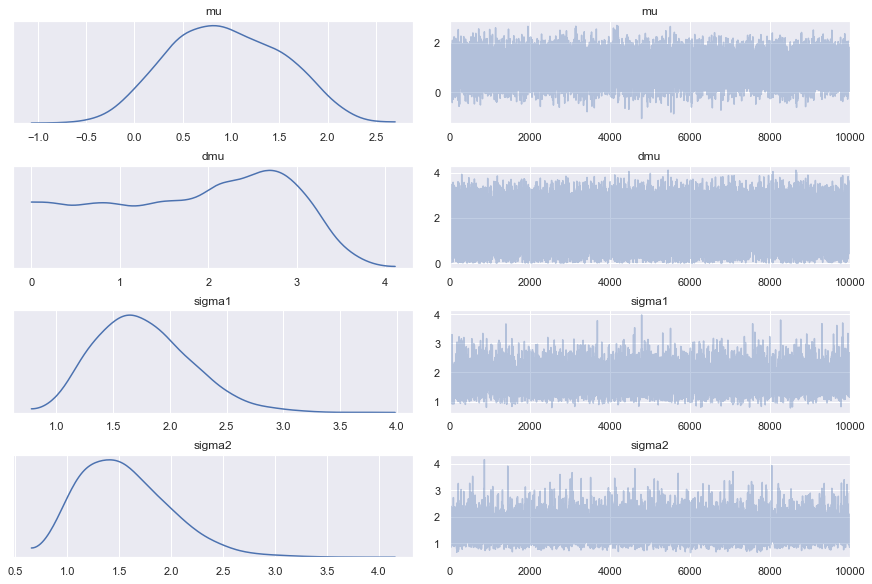

In [8]:
with model_m2:
    trace_m2 = pm.sample(SMC_STEPS, step=pm.SMC())
pm.traceplot(trace_m2[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_m2.marginal_likelihood)))

In [9]:
bf_smc_2_vs_1 = bayes_factor_smc(model_m1, model_m2)
print("Log10 of Bayes factor model m2 over model m1: %0.5f" % bf_smc_2_vs_1)

Log10 of Bayes factor model m2 over model m1: 12.05800


# BAR estimator

In [10]:
def bayes_factor_uniform_aug(model_ini, sample_ini, model_fin, sample_fin, bootstrap=None):
    
    lower_upper_fin = fit_uniform_trace(sample_fin)
    lower_upper_fin = {"dmu_interval__": lower_upper_fin["dmu_interval__"],
                       "sigma2_interval__": lower_upper_fin["sigma2_interval__"]}
    
    # potential for sample drawn from i estimated at state i
    nsamples_ini = len(sample_ini["mu_interval__"])
    sample_aug_ini = draw_uniform_samples(lower_upper_fin, nsamples_ini)
    u_i_i = pot_ener_uniform_aug(sample_ini, model_ini, sample_aug_ini, lower_upper_fin)
    
    # potential for sample drawn from i estimated at state f
    sample_ini_comb = {"mu_interval__": sample_ini["mu_interval__"],
                       "sigma1_interval__": sample_ini["sigma_interval__"]}
    sample_ini_comb.update(sample_aug_ini)
    u_i_f = pot_ener(sample_ini_comb, model_fin)
    
    # potential for sample drawn from f estimated at state f
    u_f_f = pot_ener(sample_fin, model_fin)
    
    # potential for sample drawn from f estimated at state i
    sample_fin_split = {"mu_interval__": sample_fin["mu_interval__"], 
                        "sigma_interval__": sample_fin["sigma1_interval__"]}
    sample_aug_fin = {"dmu_interval__": sample_fin["dmu_interval__"], 
                      "sigma2_interval__": sample_fin["sigma2_interval__"]}
    u_f_i = pot_ener_uniform_aug(sample_fin_split, model_ini, sample_aug_fin, lower_upper_fin)
    
    w_F = u_i_f - u_i_i
    w_R = u_f_i - u_f_f

    delta_F = pymbar.BAR(w_F, w_R, compute_uncertainty=False, relative_tolerance=1e-12, verbose=True)
    bf = -delta_F

    if bootstrap is None:
        print("log10(bf) = %0.5f" % (bf *np.log10(np.e)))
        return bf
    else:
        print("Running %d bootstraps to estimate error." % bootstrap)
        bf_err = bootstrap_BAR(w_F, w_R, bootstrap)
        print("log10(bf) = %0.5f +/- %0.5f" % (bf * np.log10(np.e), bf_err * np.log10(np.e)))
        return bf, bf_err

In [11]:
def repeat_sample(sample, repeats):
    sample = sample.copy()
    for k in sample.keys():
        sample[k] = np.repeat(sample[k], repeats)
    return sample

# Metropolis MC

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 201000/201000 [01:08<00:00, 2953.52draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c27486518>,
      dtype=object)

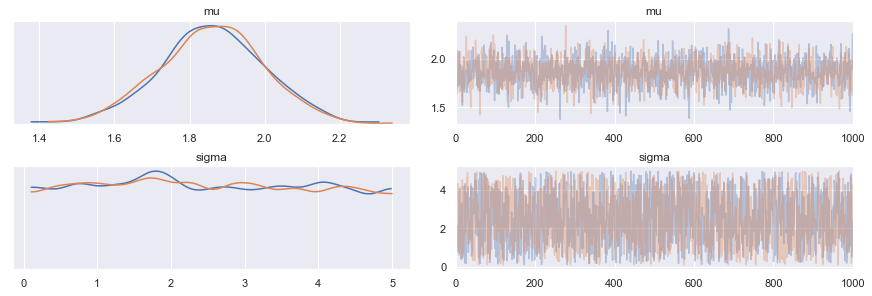

In [12]:
with model_m1:
    trace_m1 = pm.sample(MET_STEPS, step=pm.Metropolis())
pm.traceplot(trace_m1[::100])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma2]
>Metropolis: [sigma1]
>Metropolis: [dmu]
>Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 201000/201000 [02:14<00:00, 1495.20draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25746588>,
      dtype=object)

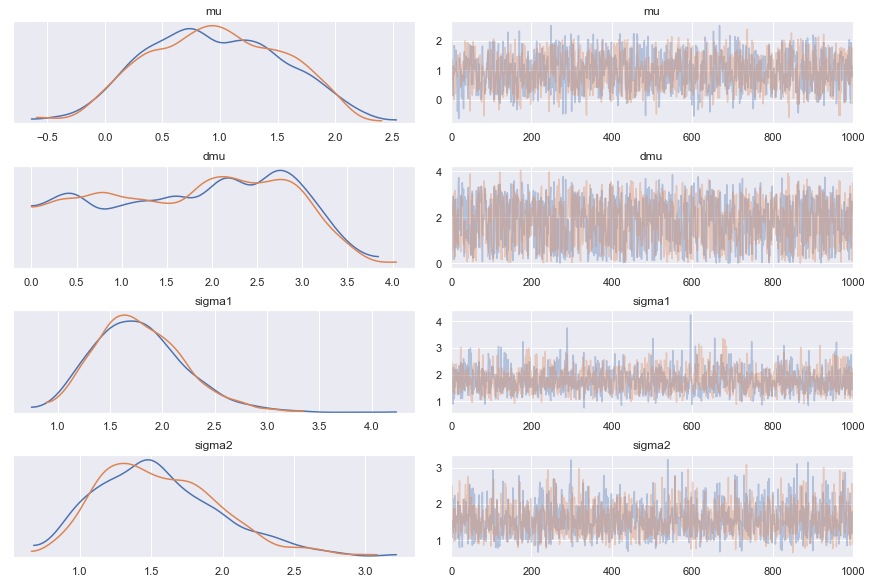

In [13]:
with model_m2:
    trace_m2 = pm.sample(MET_STEPS, step=pm.Metropolis())
pm.traceplot(trace_m2[::100])

In [22]:
sample_m1 = get_values_from_trace(model_m1, trace_m1, thin=100, burn=10)
sample_m2 = get_values_from_trace(model_m2, trace_m2, thin=100, burn=10)

# Augmenting with uniformly-drawn samples

In [27]:
bayes_factor_uniform_aug(model_m1, sample_m1, model_m2, sample_m2, bootstrap=100)

Initial brackets did not actually bracket, widening them
Initial brackets did not actually bracket, widening them
Initial brackets did not actually bracket, widening them
relative_change =        1.000
iteration     0: DeltaF =          -27.590
relative_change =        0.000
iteration     1: DeltaF =          -27.598
relative_change =        0.000
iteration     2: DeltaF =          -27.598
relative_change =        0.000
iteration     3: DeltaF =          -27.598
relative_change =        0.000
Convergence achieved.
Converged to tolerance of 3.646942e-13 in 4 iterations (13 function evaluations)
DeltaF =  -27.598
Running 100 bootstraps to estimate error.
log10(bf) = 11.98567 +/- 0.04253


(27.598021620790025, 0.09792550068123228)

## Augmenting 10 more times

In [28]:
sample_m1_repeat = repeat_sample(sample_m1, 10)
bayes_factor_uniform_aug(model_m1, sample_m1_repeat, model_m2, sample_m2, bootstrap=100)

Initial brackets did not actually bracket, widening them
Initial brackets did not actually bracket, widening them
Initial brackets did not actually bracket, widening them
Initial brackets did not actually bracket, widening them
Initial brackets did not actually bracket, widening them
Initial brackets did not actually bracket, widening them
relative_change =        1.000
iteration     0: DeltaF =          -27.637
relative_change =        0.000
iteration     1: DeltaF =          -27.639
relative_change =        0.000
iteration     2: DeltaF =          -27.639
relative_change =        0.000
Convergence achieved.
Converged to tolerance of 1.542473e-14 in 3 iterations (18 function evaluations)
DeltaF =  -27.639
Running 100 bootstraps to estimate error.
log10(bf) = 12.00351 +/- 0.02600


(27.639095815316498, 0.05986409668997866)

# Use wider priors

## Model 3

In [31]:
with pm.Model() as model_m3:
    mu = pm.Uniform("mu", lower=-50, upper=50)
    sigma = pm.Uniform("sigma", lower=0.1, upper=10)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=x)

print(model_m3.vars)

[mu_interval__, sigma_interval__]


## Model 4

In [34]:
with pm.Model() as model_m4:
    w = pm.floatX([.5, .5])
    sigmas = pm.floatX([1., 1])
    
    mu = pm.Uniform("mu", lower=-50, upper=50)
    dmu = pm.Uniform("dmu", lower=0, upper=50)
    means = tt.zeros([2])
    means = tt.set_subtensor(means[0], mu)
    means = tt.set_subtensor(means[1], mu + dmu)
    
    sigma1 = pm.Uniform("sigma1", lower=0.1, upper=10)
    sigma2 = pm.Uniform("sigma2", lower=0.1, upper=10)
    sigmas = tt.zeros([2])
    sigmas = tt.set_subtensor(sigmas[0], sigma1)
    sigmas = tt.set_subtensor(sigmas[1], sigma2)
    
    obs = pm.NormalMixture("obs", w=w, mu=means, sigma=sigmas, observed=x)

print(model_m4.vars)

[mu_interval__, dmu_interval__, sigma1_interval__, sigma2_interval__]


## Sequential Monte Carlo

Sample initial stage: ...
Stage: 0 Beta: 0.000 Steps: 25
Stage: 1 Beta: 0.001 Steps: 7
Stage: 2 Beta: 0.006 Steps: 3
Stage: 3 Beta: 0.042 Steps: 5
Stage: 4 Beta: 0.310 Steps: 4
Stage: 5 Beta: 1.000 Steps: 4


Log10 marginal likelihood: -60.51919


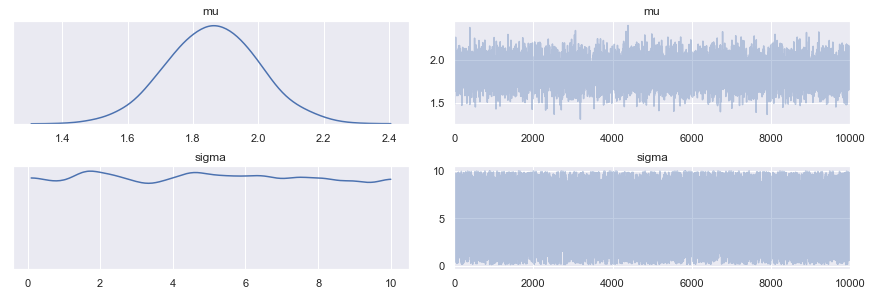

In [35]:
with model_m3:
    trace_m3 = pm.sample(SMC_STEPS, step=pm.SMC())
pm.traceplot(trace_m3[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_m3.marginal_likelihood)))

In [36]:
with model_m4:
    trace_m4 = pm.sample(SMC_STEPS, step=pm.SMC())
pm.traceplot(trace_m4[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_m4.marginal_likelihood)))

Sample initial stage: ...
Stage: 0 Beta: 0.006 Steps: 25
Stage: 1 Beta: 0.030 Steps: 14
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-beb0ab5fe492>", line 2, in <module>
    trace_m4 = pm.sample(SMC_STEPS, step=pm.SMC())
  File "//anaconda3/lib/python3.7/site-packages/pymc3/sampling.py", line 340, in sample
    random_seed=random_seed)
  File "//anaconda3/lib/python3.7/site-packages/pymc3/step_methods/smc.py", line 197, in sample_smc
    pool = mp.Pool(processes=cores)
  File "//anaconda3/lib/python3.7/multiprocessing/context.py", line 119, in Pool
  File "//anaconda3/lib/python3.7/multiprocessing/pool.py", line 158, in __init__
  File "//anaconda3/lib/python3.7/multiprocessing/pool.py", line 252, in _setup_queues
  File "//anaconda3/lib/python3.7/multiprocessing/context.py", line 112, in SimpleQueue
  File "//anaconda3/lib/python3.7/multiprocessing/queues.py", line 337, in __init__
  File "//anacond

OSError: [Errno 24] Too many open files